In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import psytrack as psy

## Quick Demo : Let's say a certain process produces time-varying weights, which when acting upon a certain set of inputs, will create output choices. So, we have the input x and the generated output y. How can psytrack help recover the weights ? In other words, perform the dynamic log reg to find weights for this regression problem.

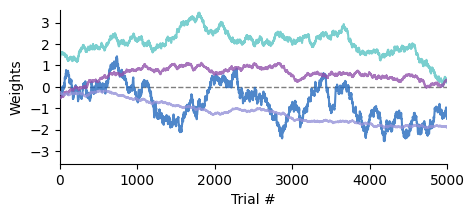

In [2]:
seed = 31
num_weights = 4
num_trials = 5000
hyper = {'sigma'   : 2**np.array([-4.0,-5.0,-6.0,-7.0]),
         'sigInit' : 2**np.array([ 0.0, 0.0, 0.0, 0.0])}

# Simulate
simData = psy.generateSim(K=num_weights, N=num_trials, hyper=hyper,
                          boundary=6.0, iterations=1, seed=seed, savePath=None)

# Plot
psy.plot_weights(simData['W'].T);
plt.ylim(-3.6,3.6);

In [4]:
simData.get('X')

array([[-1.53838712,  0.42103903,  0.41645744, -0.68211591],
       [ 0.10428459, -1.51795415, -0.57449161, -0.05326662],
       [ 0.64070616,  2.27887192,  0.72229007, -0.66272997],
       ...,
       [ 0.26584933,  2.0332635 , -0.7496208 ,  0.47398381],
       [-0.17065255,  0.06548138,  0.50212868,  1.55632706],
       [ 1.20698087, -0.53682278, -0.60912088, -0.17290518]])

In [5]:
simData.get('W')

array([[-0.4343693 ,  1.34700479, -0.49779972, -0.2405024 ],
       [-0.43356056,  1.32084552, -0.49964051, -0.25749655],
       [-0.47947976,  1.34969436, -0.51976486, -0.25537572],
       ...,
       [-1.48016105,  0.33025206,  0.27561389, -1.8873101 ],
       [-1.42635657,  0.29754755,  0.28747175, -1.90199806],
       [-1.49545299,  0.2715588 ,  0.27901971, -1.90278552]])

In [8]:
np.unique(simData.get('all_Y')[0])

array([1, 2])

In [9]:
rec = psy.recoverSim(simData)

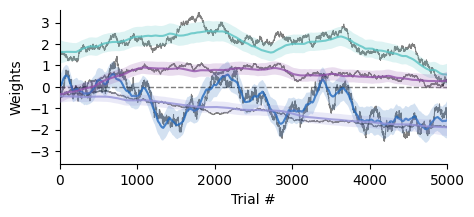

In [10]:
psy.plot_weights(rec['wMode'], errorbar=rec["hess_info"]["W_std"])
plt.plot(simData['W'], c="k", ls="-", alpha=0.5, lw=0.75, zorder=0)
plt.ylim(-3.6,3.6);

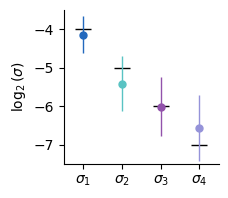

In [11]:
true_sigma = np.log2(rec['input']['sigma'])
avg_sigma = np.log2(rec['hyp']['sigma'])
err_sigma = rec['hess_info']['hyp_std']

plt.figure(figsize=(2,2))
colors = np.unique(list(psy.COLORS.values()))
for i in range(num_weights):
    plt.plot(i, true_sigma[i], color="black", marker="_", markersize=12, zorder=0)
    plt.errorbar([i], avg_sigma[i], yerr=2*err_sigma[i], color=colors[i], lw=1, marker='o', markersize=5)

plt.xticks([0,1,2,3]); plt.yticks(np.arange(-8,-2))
plt.gca().set_xticklabels([r"$\sigma_1$", r"$\sigma_2$", r"$\sigma_3$", r"$\sigma_4$"])
plt.xlim(-0.5,3.5); plt.ylim(-7.5,-3.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel(r"$\log_2(\sigma)$");

## Full Demo with real data

In [13]:
# Extract premade dataset from npz
D = np.load('D:\\neuromatch2024\\datasets\\sampleRatData.npz', allow_pickle=True)['D'].item()

print("The keys of the dict for this example animal:\n   ", list(D.keys()))

The keys of the dict for this example animal:
    ['name', 'y', 'answer', 'correct', 'dayLength', 'inputs']


In [16]:
D['inputs'].keys()

dict_keys(['h', 'r', 'c', 's1', 's2', 's_avg'])

In [19]:
D['inputs']["h"]

array([[-1.,  0.],
       [ 1., -1.],
       [ 1.,  1.],
       ...,
       [-1., -1.],
       [ 1., -1.],
       [-1.,  1.]])

In [20]:
D['inputs']["r"]

array([[-1.,  0.],
       [ 1., -1.],
       [ 1.,  1.],
       ...,
       [ 1.,  1.],
       [-1.,  1.],
       [ 1., -1.]])

In [21]:
D['inputs']["c"]

array([[ 1.,  0.],
       [ 1.,  1.],
       [ 1.,  1.],
       ...,
       [-1., -1.],
       [-1., -1.],
       [-1., -1.]])

In [22]:
D['inputs']["s1"]

array([[-0.04184135, -0.04184135],
       [ 1.51889035, -0.04184135],
       [ 0.73846325,  1.51889035],
       ...,
       [ 1.59603762, -1.39664247],
       [ 0.84765711,  1.59603762],
       [ 0.10037948,  0.84765711]])

In [23]:
D['inputs']["s2"]

array([[-0.82166801,  0.73846325],
       [ 0.73846325, -0.82166801],
       [-0.04184135,  0.73846325],
       ...,
       [ 0.84765711, -0.64849422],
       [ 1.59603762,  0.84765711],
       [ 0.84765711,  1.59603762]])

In [24]:
D['inputs']["s_avg"]

array([[ 0.34831095,  0.        ],
       [-0.43175468,  0.34831095],
       [ 1.1286768 , -0.43175468],
       ...,
       [-1.02256834,  0.4740183 ],
       [ 1.22184736, -1.02256834],
       [ 1.22184736,  1.22184736]])

In [25]:
weights = {'bias': 1,  # a special key
           's1': 1,    # use only the first column of s1 from inputs
           's2': 1}    # use only the first column of s2 from inputs

# It is often useful to have the total number of weights K in your model
K = np.sum([weights[i] for i in weights.keys()])

In [27]:
hyper= {'sigInit': 2**4.,      # Set to a single, large value for all weights. Will not be optimized further.
        'sigma': [2**-4.]*K,   # Each weight will have it's own sigma optimized, but all are initialized the same
        'sigDay': None}

In [28]:
optList = ['sigma']

In [29]:
new_D = psy.trim(D, END=10000)

In [30]:
hyp, evd, wMode, hess_info = psy.hyperOpt(new_D, hyper, weights, optList)

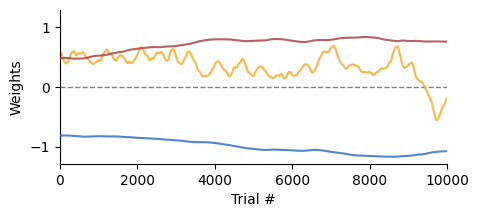

In [31]:
fig = psy.plot_weights(wMode, weights)

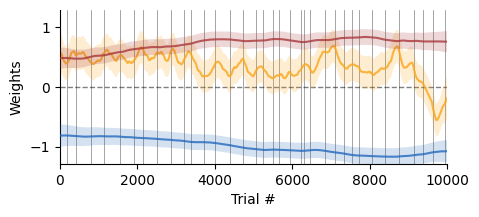

In [32]:
fig = psy.plot_weights(wMode, weights, days=new_D["dayLength"], errorbar=hess_info["W_std"])

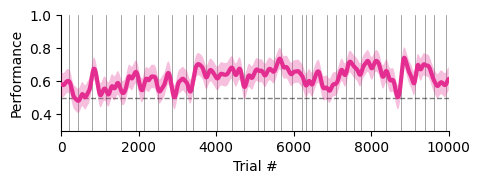

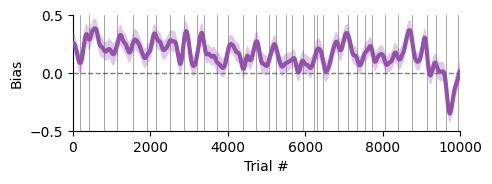

In [34]:
fig_perf = psy.plot_performance(new_D)
fig_bias = psy.plot_bias(new_D)

In [35]:
xval_logli, xval_pL = psy.crossValidate(new_D, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

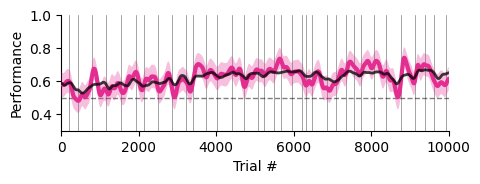

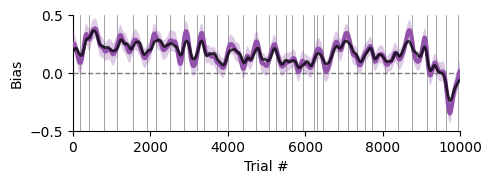

In [36]:
fig_perf_xval = psy.plot_performance(new_D, xval_pL=xval_pL)
fig_bias_xval = psy.plot_bias(new_D, xval_pL=xval_pL)